In [1]:
import sys
sys.path.append('../')
import pickle
from scipy.io import mmread

from config import car_model_directory as model_directory
from utils import remove_alphabet_number_comb
from utils import read_list

index2category = read_list('./car_index.txt')
with open('{}/common_words.pkl'.format(model_directory), 'rb') as f:
    common_words = pickle.load(f)
with open('{}/category_sensitive_words.pkl'.format(model_directory), 'rb') as f:
    category_sensitive_words = pickle.load(f)
with open('{}/subword_df_slot.pkl'.format(model_directory), 'rb') as f:
    params = pickle.load(f)
    index2subword = params['index2subword']
    subword2index = {subword:index for index,subword in enumerate(index2subword)}
    del params
    
print(common_words['차량']) # (nstd, mean, max/mean, argmax_c)

(0.18567, 0.54834, 1.2969, 20)


In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
for c, words in enumerate(category_sensitive_words):
    print(c, len(words))

0 3752
1 834
2 572
3 2968
4 3082
5 3267
6 209
7 146
8 319
9 1229
10 1138
11 139
12 120
13 118
14 178
15 78
16 370
17 334
18 237
19 219
20 156
21 586
22 236
23 269
24 1290
25 1472
26 2142


In [5]:
c = 0
with open('{}/related_words_c{}.pkl'.format(model_directory, c), 'rb') as f:
    W_ij = pickle.load(f)
#     sensitive_words = set(category_sensitive_words[c])
#     common_words = set(common_words)
sensitive_words = set(remove_alphabet_number_comb(category_sensitive_words[c]))
common_words = set(remove_alphabet_number_comb(common_words))
true_specific, false_specific, has_no_relateds = select_specific_words(W_ij, sensitive_words, common_words, cost_factor=1.0, cutoff=0.00)

In [6]:
print('category = {}'.format(index2category[c]))
print('True specific')
print(remove_alphabet_number_comb([word for word, _ in true_specific]))
print('\nFalse specific (common words)')
print(remove_alphabet_number_comb([word for word, _ in false_specific]))
print('\nHas no related words')
print(remove_alphabet_number_comb([word for word, _ in has_no_relateds]))

category = A6
True specific
['베르디', '우니', '정혁', '부육셰히르', '드니프로', '야마가', '리베르', '투르크', '에스파뇰', '벨레', '시타', '로코모티', '상파울', '일리치', '나시오날', '세비야', '아라우', '올림피', '감바', '부르크', '우니베르시', '마스트', '하그', '올림피아', '캔자스', '레인저', '투르', '도르', '비토', '비야', '스파르타', '로스토', '알메', '페레', '크레테', '바레', '칩셋', '아이팟터치', '쿼드코어', '주상복합', '아이패드3', '출시국', '홈버튼', '입주예정', '입주민', '아이패드2', '입주가', '아이패드에', '레티나', 'A6블록', '아이폰5C', 'A6칩', '아이폰5s', '뉴아이패드', '아이폰5', '택지지구', '아이폰4S', 'A6블', '택지', '아이폰5에', '아이폰4', '아이폰5S', '입주자', '광명역세권', '시흥목감', '미사강변', '게이밍', '한라비발디', '포스코건설', '운정역', '엠코타운', '가람마을', '아티브', '지속시간', '대시보드뜯', '콘솔뜯', '다시방뜯', '플라스틱뜯', '핸들뜯', '코어i']

False specific (common words)
['우레탄도', '나츠', '페르소나', '레슬', '라데', '세라믹브', '수입차밋션', '학점은', '아우토엠', '터치네비게이션', '경동오토미션', '대명오토', '에뮬', '아우디A6중고', '히아트모터스', '대전exLED', '미러웍스', '레보', '범퍼몰', '뉴아우디', '유카로', '아우디A6네비', '모빌리언스', '밀텍', '아식', '베리어스', '아우디사', '아우디A6차량', '아우디뉴A6', 'A6차량', '제조아우디차명', 'A6에', '콰트로가', 'A6모델']

Has no related words
['히로시', '글렌', '수입차브', '벤츠네비', '아우디s', '

In [121]:
positive_features = {word for word in common_words}
positive_features.update([word for word, _ in false_specific])
negative_features = {word for word, _ in true_specific}
negative_features.update([word for word, _ in has_no_relateds])

positive_features = {subword2index[word] for word in positive_features}
negative_features = {subword2index[word] for word in negative_features}

x_fname = '{}/subword_tf_c{}.mtx'.format(model_directory, c)
x = mmread(x_fname).tocsr()

In [122]:
def classify_documents(x, positive_features, negative_features, negative_score_factor=1.0):
    n, m = x.shape
    factor = negative_score_factor * len(negative_features) / len(positive_features)
    
    rows, cols = x.nonzero()
    data = x.data
    scores = [0]*n
    unknown_features = [0]*n
    num_features = [0]*n
    normalizer = [0]*n
    
    n_entry = len(rows)
    for i_entry, (i,j,d) in enumerate(zip(rows, cols, data)):
        if i_entry % 5000 == 4999:
            print('\r  - computing ... {} % entries'.format('%.2f'%(100*(i_entry+1)/n_entry)), flush=True, end='')
        num_features[i] = num_features[i] + d
        if j in positive_features:
            scores[i] = scores[i] + d
            normalizer[i] = normalizer[i] + d
        if j in negative_features:
            scores[i] = scores[i] - (factor * d)
            normalizer[i] = normalizer[i] + (factor * d)
        if not (j in positive_features or j in negative_features):
            unknown_features[i] = unknown_features[i] + d
            #scores[i] = scores[i] - d * factor
    scores = [score/normalizer[i] if normalizer[i] > 0 else 0 for i,score in enumerate(scores)]
    unknown_features = [num/num_features[i] for i,num in enumerate(unknown_features) if num_features[i] > 0]
    print('\rclassification was done.{}'.format(' '*50))
    return scores, num_features, unknown_features

In [134]:
scores, num_features, unknown_features = classify_documents(x, positive_features, negative_features, negative_score_factor=100)

classification was done.                                                  


In [135]:
print('len scores =',len(scores))
print('len counter(scores) =',len(Counter(scores)))

len scores = 61924
len counter(scores) = 6824


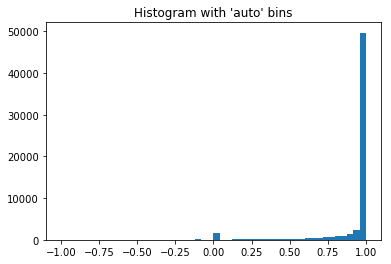

In [136]:
plt.hist(scores, bins=50)
plt.title("Histogram with 'auto' bins")
plt.show()

In [68]:
def make_bow(doc, topk=30):
    import re
    regex = '^[a-zA-Z0-9]+$'
    
    bow = x[doc,:]
    term = bow.nonzero()[1]
    data = bow.data
    bow = sorted([(t,tf) for t,tf in zip(term, data)], key=lambda x:-x[1])
    bow = [(index2subword[t],tf) for t,tf in bow]
    bow = [(t,tf) for t,tf in bow if not re.match(regex, t)][:topk]
    return bow


In [137]:
negative = [i for i, score in enumerate(scores) if score < 0.5]
positive = [i for i, score in enumerate(scores) if score > 0.5]
print(len(negative), len(positive))

3532 58392


In [138]:
scores[15]

0.048560989365789085

In [141]:
_counter = 0
for doc in negative:
# for doc in positive:
    bow = make_bow(doc)
    if not bow:
        continue
    print('#doc={}, score={:.4}, unknown_features={:.4}, num_features={}'.format(doc, float(scores[doc]), float(unknown_features[doc]), num_features[doc]))
    print(bow, '\n')
    _counter += 1
    if _counter > 100: break

#doc=15, score=0.04856, unknown_features=0.1682, num_features=220
[('아이', 23), ('아이폰', 23), ('아이폰4', 9), ('아이폰5', 9), ('디자인', 7), ('예상', 6), ('뉴아', 5), ('뉴아이', 5), ('뉴아이패드', 5), ('디스', 5), ('디스플레이', 5), ('레티나', 5), ('아이폰5에', 5), ('이렇게', 4), ('카메라', 4), ('나올', 3), ('디자인이', 3), ('확률', 3), ('나왔', 2), ('나왔으', 2), ('알려', 2), ('애플', 2), ('좋겠', 2), ('1200만', 1), ('A6칩', 1), ('ㅠㅠ', 1), ('ㅠㅠㅠ', 1), ('ㅠㅠㅠㅠ', 1), ('ㅠㅠㅠㅠㅠ', 1), ('같았', 1)] 

#doc=22, score=-0.2224, unknown_features=0.9379, num_features=757
[('노르', 3), ('그라', 2), ('마카', 2), ('브라', 2), ('유나', 2), ('포르', 2), ('28일', 1), ('경기', 1), ('고아', 1), ('골든', 1), ('그린', 1), ('김대', 1), ('노르웨이', 1), ('더블', 1), ('도르', 1), ('레알', 1), ('로버', 1), ('로테', 1), ('모스', 1), ('모스크바', 1), ('뮌헨', 1), ('미트', 1), ('바레', 1), ('바이', 1), ('바이에른', 1), ('박수', 1), ('반필드', 1), ('베를', 1), ('베를린', 1), ('벨기에', 1)] 

#doc=23, score=-0.4192, unknown_features=0.4868, num_features=152
[('운정', 9), ('한라', 8), ('한라비', 8), ('한라비발디', 8), ('운정역', 7), ('1층', 5), ('가람마을', 4), ('파주', 

#doc=2609, score=0.3589, unknown_features=0.3541, num_features=466
[('광명', 28), ('광명역', 23), ('파크', 6), ('푸르', 6), ('푸르지오', 6), ('호반', 6), ('효성', 6), ('개발', 5), ('광명역세권', 5), ('오피', 5), ('오피스', 5), ('오피스텔', 5), ('이용', 5), ('중심', 5), ('중심상', 4), ('퍼스', 4), ('퍼스트', 4), ('개통', 3), ('대중', 3), ('대중교통', 3), ('도보', 3), ('롯데', 3), ('면적', 3), ('시흥', 3), ('시흥목감', 3), ('아울', 3), ('위치', 3), ('있다', 3), ('코스', 3), ('코스트', 3)] 

#doc=2620, score=0.1575, unknown_features=0.6257, num_features=179
[('미니', 8), ('아우디', 8), ('벤츠', 6), ('5시', 2), ('5시리즈', 2), ('네비', 2), ('모니터', 2), ('벤츠네비', 2), ('벤츠네비게이션', 2), ('벤츠매', 2), ('수입차', 2), ('핸드', 2), ('핸드폰', 2), ('BMW5시리즈', 1), ('BMW네비', 1), ('BMW리', 1), ('BMW매', 1), ('BMW미니', 1), ('bmw리', 1), ('구로', 1), ('네비게이션', 1), ('뒷좌석', 1), ('리어', 1), ('리어모니터', 1), ('매립', 1), ('미니쿠퍼', 1), ('미러', 1), ('미러링', 1), ('벤츠전', 1), ('수입차네비', 1)] 

#doc=2667, score=-0.02847, unknown_features=0.3077, num_features=91
[('시흥', 5), ('시흥목감', 3), ('입주', 3), ('000원', 2), ('9월', 2), ('A6블', 2